# Quantization - Lab Session




# Introduction

This graph shows the explosive growth of deep neural networks from just 10 parameters in 1943 to an expected 100 trillion (10¹⁴) by 2025. With this growth comes a sharp rise in energy consumption, as shown by the steep curve.

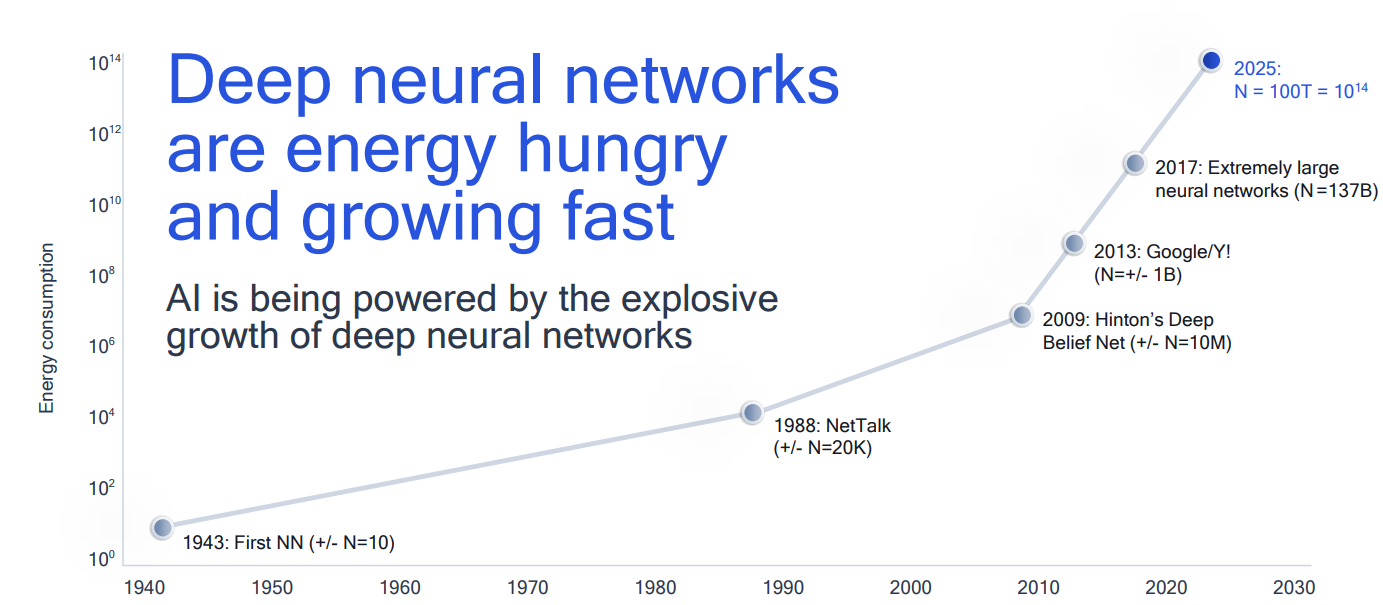

State of the art neural networks have seen tremendous success on computer vision, natural language processing,
robotics tasks.

With millions of floating-point operations, deployment of AI models in real time is challenging.

Some of the techniques for making neural networks faster and lighter

1) Architectural improvements

2) Designing new and efficient layers which can replace traditional layers

3) Neural network pruning which removes unimportant weights

4) Software and hardware optimizations

5) **Quantization techniques**

**What is Quantization?**

Model quantization is a technique for replacing a trained model’s weights with values of lower precision.

***Dequantized FP32 tensors should not deviate too much from the pre-quantized FP32 tensor.***

Quantization parameters are essential for minimizing information loss when converting from higher precision to
lower precision values.






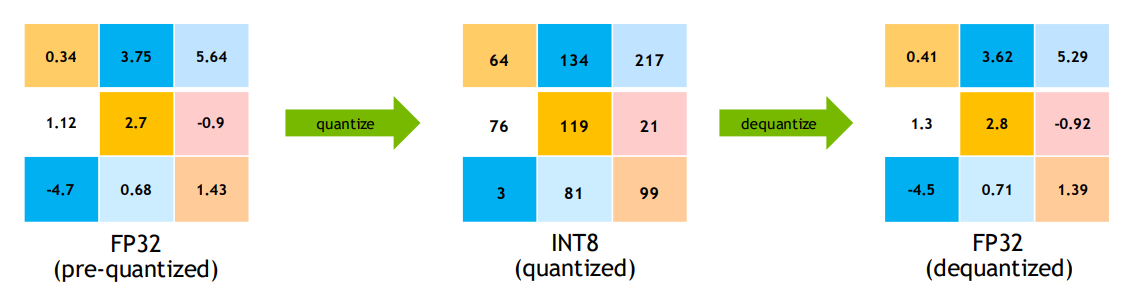



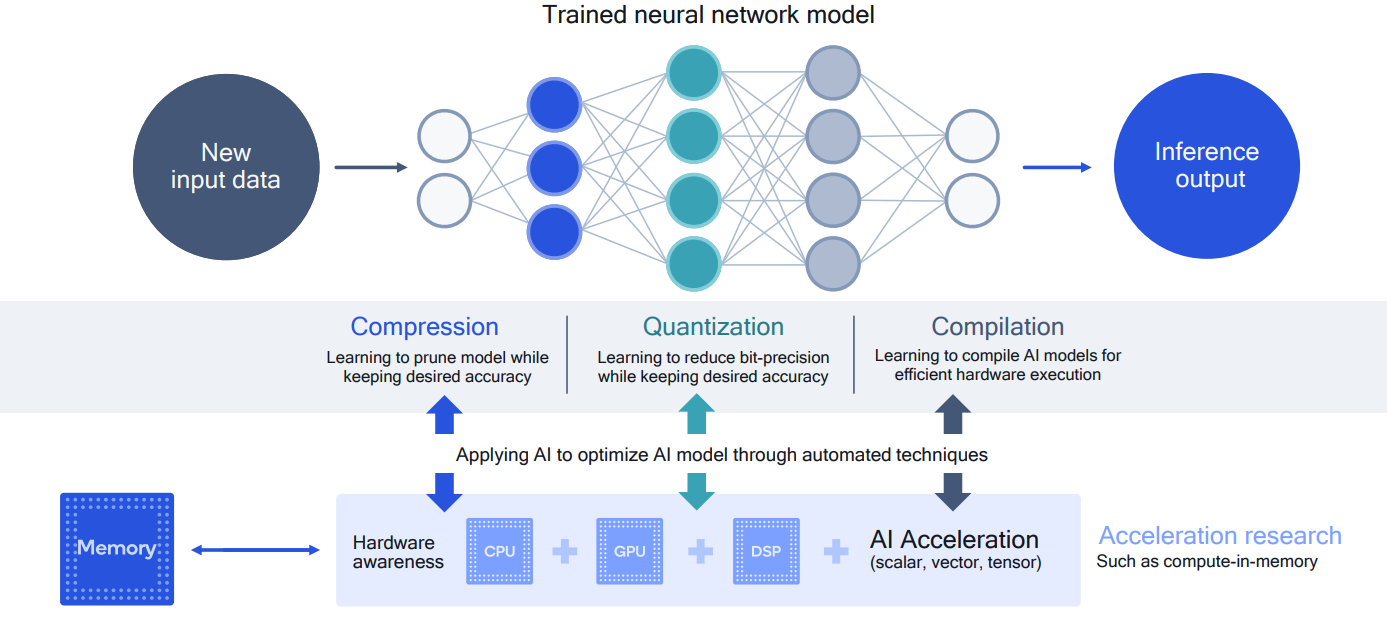

Quantizing AI models offers significant benefits

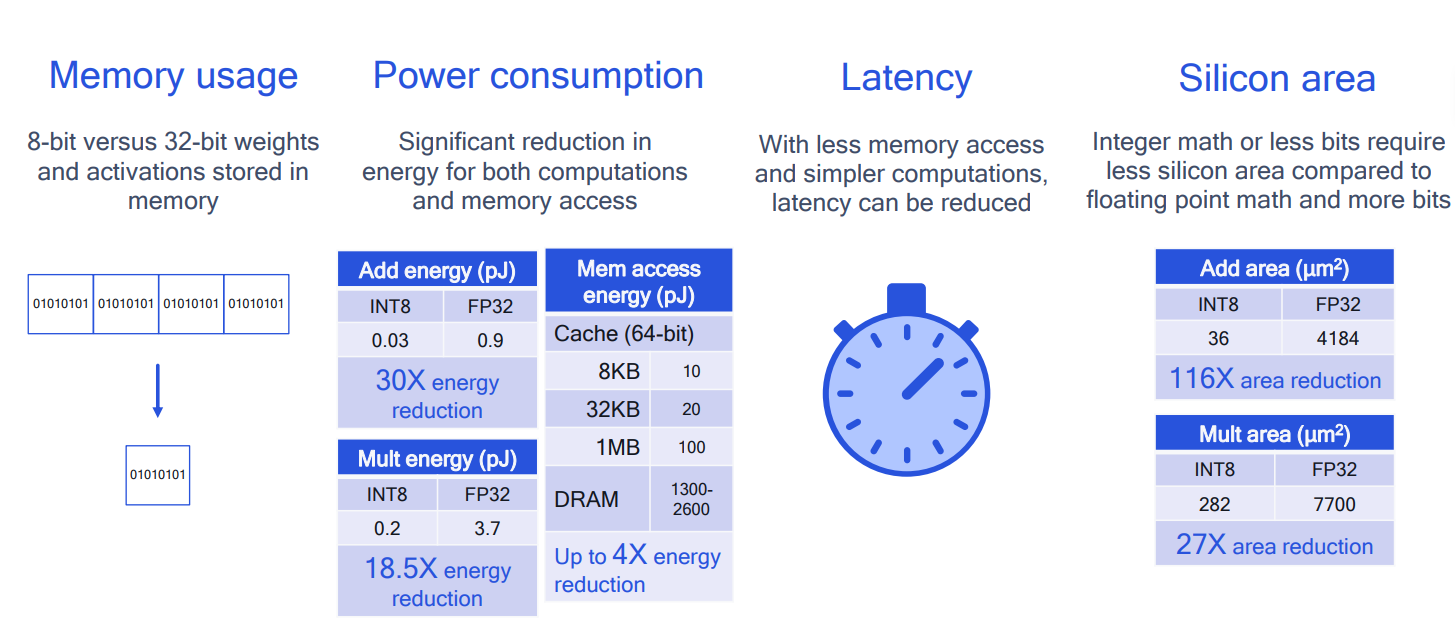

Example : Working with Eurosat Dataset

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds

# Load full dataset first
dataset, ds_info = tfds.load(
    'eurosat/rgb',
    split='train',   # load everything first
    shuffle_files=True,
    as_supervised=True,  # (image, label)
    with_info=True,
)

print(ds_info)


tfds.core.DatasetInfo(
    name='eurosat',
    full_name='eurosat/rgb/2.0.0',
    description="""
    EuroSAT dataset is based on Sentinel-2 satellite images covering 13 spectral
    bands and consisting of 10 classes with 27000 labeled and
    geo-referenced samples.
    
    Two datasets are offered:
    - rgb: Contains only the optical R, G, B frequency bands encoded as JPEG image.
    - all: Contains all 13 bands in the original value range (float32).
    
    URL: https://github.com/phelber/eurosat
    """,
    config_description="""
    Sentinel-2 RGB channels
    """,
    homepage='https://github.com/phelber/eurosat',
    data_dir='/root/tensorflow_datasets/eurosat/rgb/2.0.0',
    file_format=tfrecord,
    download_size=89.91 MiB,
    dataset_size=89.50 MiB,
    features=FeaturesDict({
        'filename': Text(shape=(), dtype=string),
        'image': Image(shape=(64, 64, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised

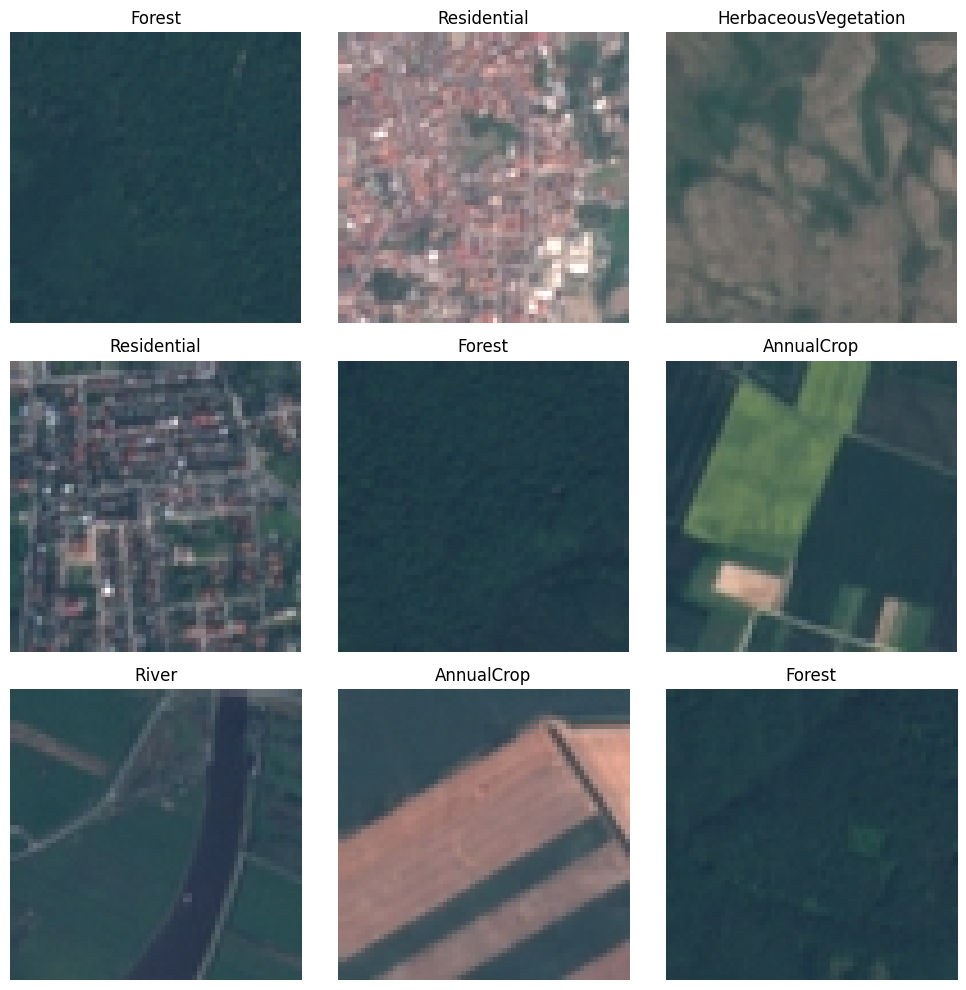

In [ ]:
import matplotlib.pyplot as plt

# Class names
class_names = ds_info.features['label'].names

# Show 9 images
plt.figure(figsize=(10,10))

for i, (image, label) in enumerate(dataset.take(9)):
    plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("uint8"))
    plt.title(class_names[label.numpy()])
    plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
# Now split into 80% training and 20% testing
train_size = 0.8
train_ds = dataset.take(int(train_size * ds_info.splits['train'].num_examples))
test_ds = dataset.skip(int(train_size * ds_info.splits['train'].num_examples))

print(f"Train size: {len(list(train_ds))}")
print(f"Test size: {len(list(test_ds))}")


Train size: 21600
Test size: 5400


In [ ]:
# Normalize the images to [0, 1] and batch the datasets
def normalize_img(image, label):
    image = tf.cast(image, tf.float32)  # Cast to float32
    image = image / 255.0  # Normalize the image values to [0, 1]
    return image, label

# Apply normalization to train and test datasets
train_ds = train_ds.map(normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_ds = test_ds.map(normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Batch and prefetch for performance optimization
train_ds = train_ds.batch(32).prefetch(tf.data.experimental.AUTOTUNE)
test_ds = test_ds.batch(32).prefetch(tf.data.experimental.AUTOTUNE)


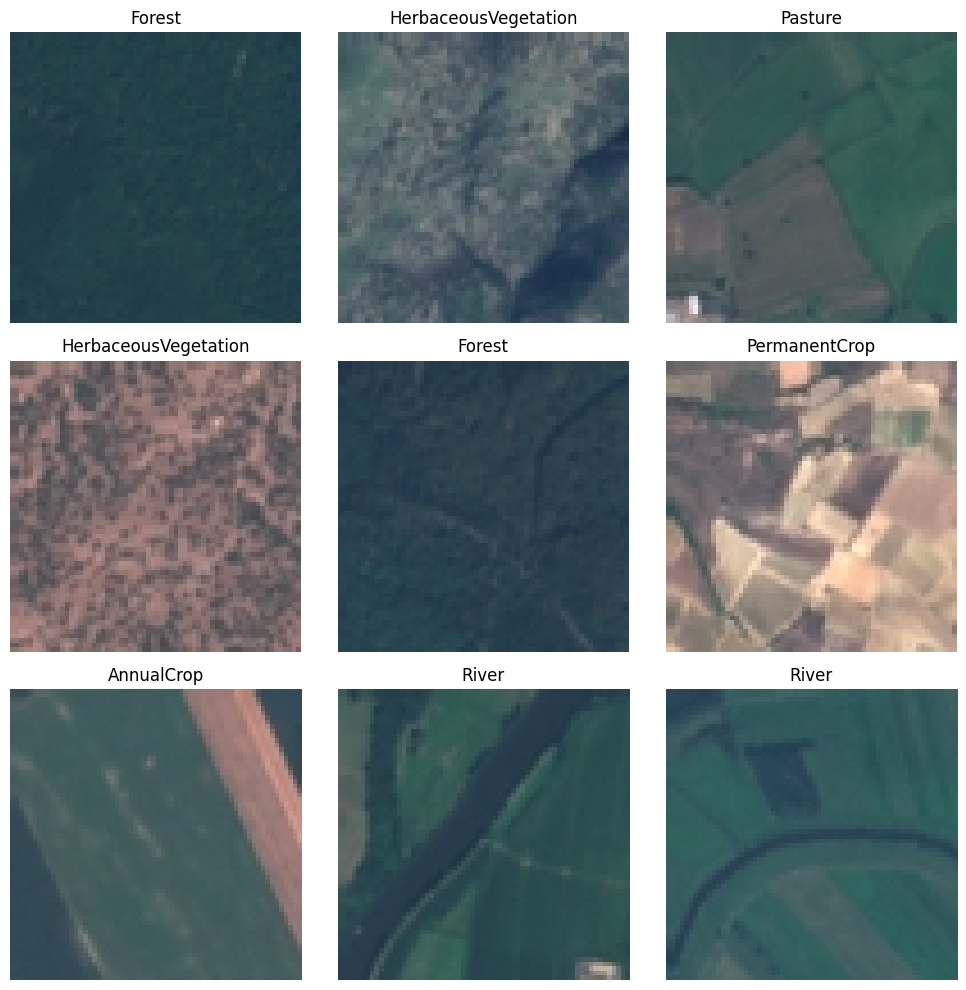

In [ ]:
# Visualize a few sample images
plt.figure(figsize=(10,10))
for i, (image, label) in enumerate(train_ds.take(9)):
    plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy()[0])  # Display the first image in the batch
    plt.title(ds_info.features['label'].int2str(label.numpy()[0]))  # Display label
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
num_classes = len(ds_info.features['label'].names)

Base Model

In [ ]:
# Build a simple CNN base model
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(64, 64, 3)),  # Input shape of the images
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')  # Output layer
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary to check the architecture
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 684,490 (2.61 MB)

 Trainable params: 684,490 (2.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model
history = model.fit(
    train_ds,
    epochs=20,  # You can adjust the number of epochs
    validation_data=test_ds,
)

Epoch 1/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 168s 245ms/step - accuracy: 0.4053 - loss: 1.5146 - val_accuracy: 0.7037 - val_loss: 0.8010
Epoch 2/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 163s 242ms/step - accuracy: 0.7217 - loss: 0.7653 - val_accuracy: 0.7811 - val_loss: 0.6182
Epoch 3/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 159s 236ms/step - accuracy: 0.7758 - loss: 0.6230 - val_accuracy: 0.7672 - val_loss: 0.6428
Epoch 4/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 202s 237ms/step - accuracy: 0.8109 - loss: 0.5338 - val_accuracy: 0.7994 - val_loss: 0.5520
Epoch 5/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 159s 236ms/step - accuracy: 0.8427 - loss: 0.4454 - val_accuracy: 0.8115 - val_loss: 0.5302
Epoch 6/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 211s 250ms/step - accuracy: 0.8615 - loss: 0.3945 - val_accuracy: 0.8343 - val_loss: 0.4918
Epoch 7/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 196s 241ms/step - accuracy: 0.8729 - loss: 0.3555 - val_accuracy: 0.8189 - val_loss: 0.5265
Epoch 8/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 200s 238ms/step - accuracy: 0.8869 -

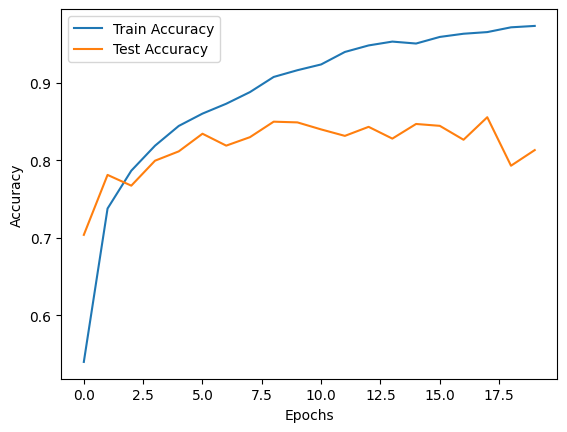

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")


169/169 ━━━━━━━━━━━━━━━━━━━━ 12s 68ms/step - accuracy: 0.8232 - loss: 1.0355
Test Accuracy: 81.31%


In [ ]:
import time
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

# First, prepare your true labels and predictions
y_true = []
y_pred = []

start_time = time.time()

for batch in test_ds:  # test_ds is your tf.data.Dataset
    images, labels = batch
    preds = model.predict(images)
    preds = np.argmax(preds, axis=1)

    y_true.extend(labels.numpy())
    y_pred.extend(preds)

end_time = time.time()
total_time = end_time - start_time
average_inference_time = total_time / len(y_true)

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='macro')

print(f"Base Model Accuracy: {accuracy:.4f}")
print(f"Base Model F1-Score: {f1:.4f}")
print(f"Average Inference Time per sample: {average_inference_time*1000:.2f} ms")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s

In [ ]:
model.save("base_model.h5")


# Types of Quantization

Quantization for neural networks can take one of the following three forms:

**Post-Training Quantization (PTQ):** this is the most widely adopted scheme, where quantization is performed after the neural network has been fully trained. At this point quantization is applied to the fitted model parameters, typically using int8 as the lower precision target.

**Quantization-Aware Training (QAT):** this technique applies quantization during the training process itself. The advantage with this approach is that the model is trained to account for the quantization process, which typically leads to better performance as the model learns to adapt to the quantization effects.

# Post-Training Quantization (PTQ):

In [ ]:
!pip install tensorflow-model-optimization


In [ ]:
# Convert model to TensorFlow Lite with Post-Training Quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

Saved artifact at '/tmp/tmp62xfc6rz'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name='keras_tensor_1')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  137936907335056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137936907335440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137936907334288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137936907334672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137936907336400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137936907336016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137936907335248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137936907336208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137936907323344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137936907326992: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [ ]:
# Save PTQ model
with open('model_ptq.tflite', 'wb') as f:
    f.write(tflite_model)


In [ ]:
# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path='model_ptq.tflite')
interpreter.allocate_tensors()

# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()


In [ ]:
import numpy as np
import time
from sklearn.metrics import accuracy_score, f1_score

y_true = []
y_pred = []

start_time = time.time()

# Loop through test dataset
for batch in test_ds:  # test_ds is your tf.data.Dataset
    images, labels = batch
    images = tf.cast(images, tf.float32)

    for i in range(images.shape[0]):
        input_data = np.expand_dims(images[i].numpy(), axis=0)

        # Resize input to match if needed
        interpreter.set_tensor(input_details[0]['index'], input_data)
        interpreter.invoke()

        output = interpreter.get_tensor(output_details[0]['index'])
        pred_label = np.argmax(output)

        y_true.append(labels[i].numpy())
        y_pred.append(pred_label)

end_time = time.time()
total_time = end_time - start_time
average_inference_time_ptq = total_time / len(y_true)


In [ ]:
# Calculate Accuracy
accurac_ptq = accuracy_score(y_true, y_pred)

# Calculate F1-Score (macro = average over all classes)
f1_ptq = f1_score(y_true, y_pred, average='macro')

print(f"PTQ Model Accuracy: {accurac_ptq:.4f}")
print(f"PTQ Model F1-Score: {f1_ptq:.4f}")
print(f"Average Inference Time per sample: {average_inference_time_ptq*1000:.2f} ms")


PTQ Model Accuracy: 0.8150
PTQ Model F1-Score: 0.8064
Average Inference Time per sample: 4.14 ms


In [ ]:
import os

def get_model_size(file_path):
    size_mb = os.path.getsize(file_path) / (1024 * 1024)
    return size_mb

base_model_size = get_model_size("base_model.h5")
print(f"Base Model Size: {base_model_size:.2f} MB")
ptq_model_size = get_model_size("model_ptq.tflite")
print(f"PTQ Model Size: {ptq_model_size:.2f} MB")

Base Model Size: 7.88 MB
PTQ Model Size: 0.66 MB


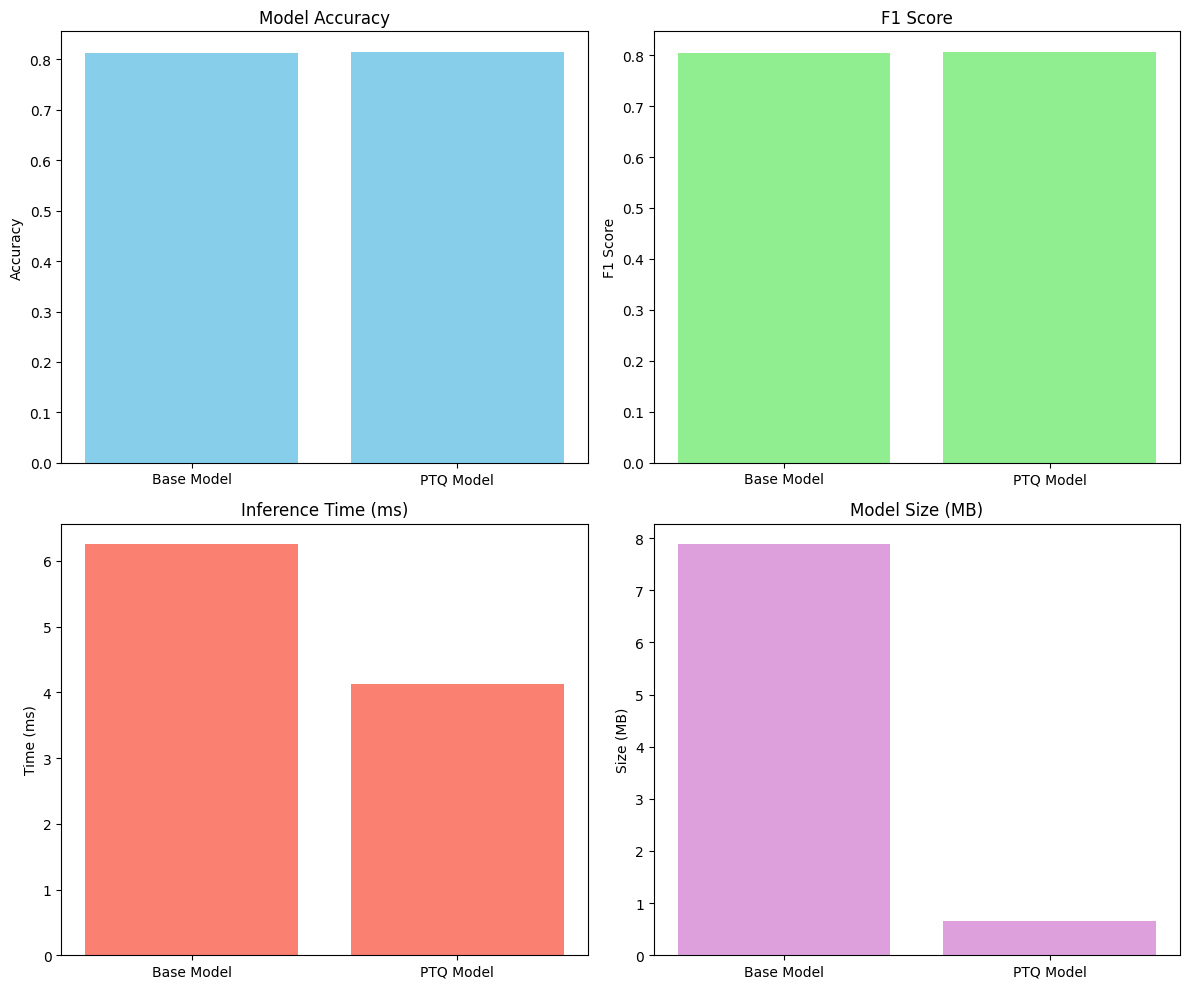

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

models = ['Base Model', 'PTQ Model']

# Metrics
accuracies = [accuracy, accurac_ptq]
f1_scores = [f1, f1_ptq]
inference_times = [average_inference_time * 1000, average_inference_time_ptq * 1000]  # in ms
model_sizes = [base_model_size, ptq_model_size]  # in MB

x = np.arange(len(models))

fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs = axs.flatten()

# Accuracy
axs[0].bar(x, accuracies, color='skyblue')
axs[0].set_title("Model Accuracy")
axs[0].set_xticks(x)
axs[0].set_xticklabels(models)
axs[0].set_ylabel("Accuracy")

# F1 Score
axs[1].bar(x, f1_scores, color='lightgreen')
axs[1].set_title("F1 Score")
axs[1].set_xticks(x)
axs[1].set_xticklabels(models)
axs[1].set_ylabel("F1 Score")

# Inference Time
axs[2].bar(x, inference_times, color='salmon')
axs[2].set_title("Inference Time (ms)")
axs[2].set_xticks(x)
axs[2].set_xticklabels(models)
axs[2].set_ylabel("Time (ms)")

# Model Size
axs[3].bar(x, model_sizes, color='plum')
axs[3].set_title("Model Size (MB)")
axs[3].set_xticks(x)
axs[3].set_xticklabels(models)
axs[3].set_ylabel("Size (MB)")

plt.tight_layout()
plt.show()


In conclusion, applying the PTQ technique resulted in the same accuracy and F1 score as the base model, but with a significantly smaller model size and much faster inference time.

Try experimenting with the QAT (Quantization Aware Training) model to observe how it performs in terms of accuracy, model size, and inference time compared to the baseline.